# パーティクルフィルタによる自己位置推定

<IPython.core.display.Javascript object>


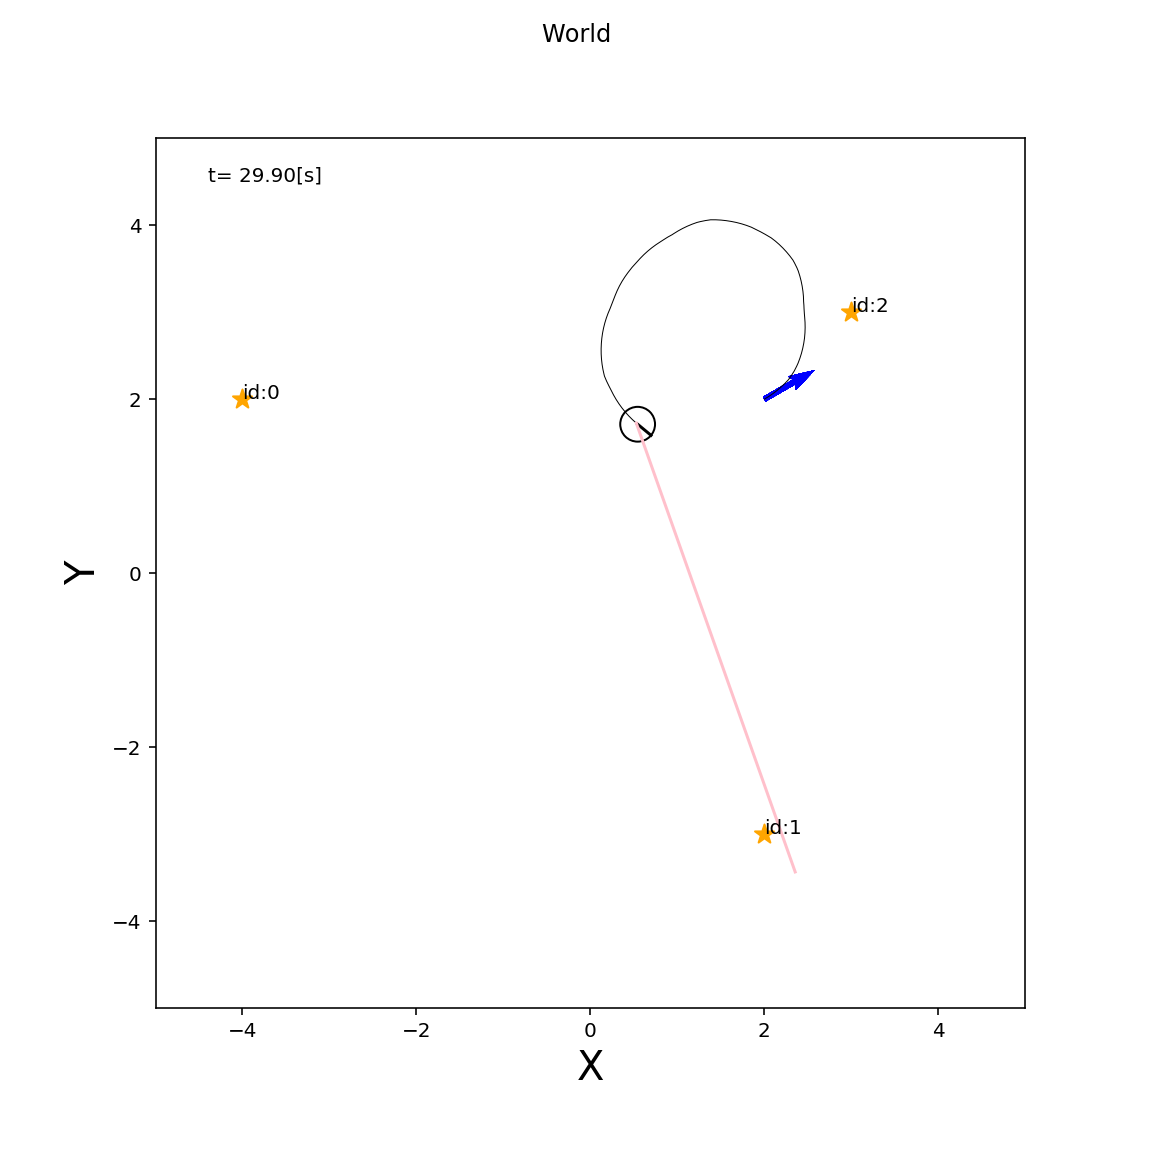

In [3]:
# 手始めにパーティクルを表示
import sys
sys.path.append('../src')
import importlib

import worlds
import maps
import numpy as np
import robots
import sensors
import agents
import landmarks
import estimators
import particles

def reload():
    importlib.reload(worlds)
    importlib.reload(maps)
    importlib.reload(robots)
    importlib.reload(sensors)
    importlib.reload(agents)
    importlib.reload(estimators)
    importlib.reload(particles)


reload()
    
world = worlds.World(30., 0.1, debuggable=False)
m = maps.Map()
for ln in [(-4., 2.), (2., -3), (3., 3.)]:
    m.append_landmark(landmarks.Point2DLandmark(*ln))
world.append(m)
    
initial_pose = np.array([2., 2., np.pi / 6.]).T
estimator = estimators.Mcl(initial_pose, 100, motion_noise_stds={'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})
circling = agents.EstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)
r = robots.Robot(initial_pose, sensor=sensors.Camera(m), agent=circling)
world.append(r)
world.draw()

パーティクルの更新

状態遷移モデルを作ろう

シミュレータでロボットの挙動の統計をとって，作っていく

ノイズが正規分布に従うと仮定してみる

このときの雑音パラメータを

- $\sigma_{\nu \nu}$ : 直進1mで生じる道のりのばらつきのstddev
- $\sigma_{\nu \omega}$ : 回転1radで生じる道のりのばらつきのstddev
- $\sigma_{\omega \nu}$ : 直進1mで生じる回転のばらつきのstddev
- $\sigma_{\omega \omega}$ : 回転1radで生じる回転のばらつきのstddev

$\sigma_{a b}$は，$b$が$a$にあたえるばらつきのstddevを表す

$b$があたえる雑音$\delta_{ab}$は移動量・回転量に比例するので

$$
\delta^{2}_{ab} : \left(\delta^{\prime}_{ab} \Delta t \right)^{2} = 1 : |b| \Delta t \\
\\
\delta^{\prime}_{ab} = \delta_{ab} \sqrt{|b| / \Delta t}
$$

$a$, $b$に$\nu$, $\omega$を代入すると制御指令に加えるべき雑音がわかる

これを${\bf \it u}^{\prime}$とすると

$$
\left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) = \left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) + \left(
    \begin{array}{c}
        \delta_{\nu \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \nu} \sqrt{|\omega|  / \Delta t} \\
        \delta_{\omega \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \omega} \sqrt{|\omega|  / \Delta t}
\end{array}
\right)
$$

シミュレータでロボットを走らせて，これらの値を計測する

In [2]:
# 実装確認コード
reload()

init_pose = np.array([0., 0., 0.]).T
estimator = estimators.Mcl(
    init_pose, 100, 
    motion_noise_stds={'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})
a = agents.EstimationAgent(0.1, 0.2, 10./180.*np.pi, estimator)
estimator.motion_update(0.2, 10./180.*np.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[0.01801601 0.00020635 0.02290693]
[0.01742536 0.00015976 0.01833606]
[0.02309869 0.00018889 0.0163551 ]
[0.02081782 0.00018102 0.01739   ]
[1.92732065e-02 4.90457565e-05 5.08951645e-03]
[0.0191327  0.00011758 0.01229104]
[0.01884067 0.00019499 0.02069821]
[0.0169353  0.000122   0.01440704]
[0.02618562 0.00028481 0.02175258]
[0.02468724 0.00025649 0.02077846]
[0.02504604 0.000298   0.02379485]
[0.02073828 0.00019025 0.0183471 ]
[0.02039043 0.0001342  0.01316322]
[0.0169281  0.00019967 0.02358931]
[0.01832113 0.00023776 0.02595354]
[0.02148958 0.00014617 0.01360351]
[0.02303114 0.00031047 0.02695919]
[0.0228349  0.00039667 0.03473924]
[0.01883562 0.00017605 0.01869274]
[0.02113701 0.00031703 0.02999529]
[1.90234056e-02 1.74540129e-05 1.83500351e-03]
[0.02025345 0.00024503 0.02419524]
[0.0165737  0.00013889 0.01676004]
[0.02077406 0.00014838 0.01428467]
[1.88982022e-02 9.24306531e-05 9.78187396e-03]
[1.86173494e-02 7.42288467e-05 7.97411617e-03]
[0.01677588 0.00013332 0.01589342]
[2.1406